# List of all sales: Holiday homes in R&oslash;rvig, Denmark sold since 1992
For now, let's ignore listed prices and amount of time listed. Let's just look at:
* Price differences between regular sales ('Alm. frit salg') and family sales ('Familieoverdragelse')
* Years/months with most sales (when are the seasons?)

## Load libraries

In [1]:
import requests
import time
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import json
import boliga
from rorvig import include_map
#import geopandas as gpd
#from mpl_toolkits.basemap import Basemap
#import leafmap

## Load data
### List of all properties (`bbrsearch` from `bbrsearch_noghosts.txt`)

In [2]:
with open('bbrsearch_noghosts.txt', 'r') as file:
    bbrsearch = json.load(file)

### Previous sales and listings (`soldinfo` from `soldinfo.txt`, with guids from `bbrsearch`)

In [3]:
with open('soldinfo.txt', 'r') as file:
    soldinfo = json.load(file)

## Combine with `soldinfo`
**Example of soldinfo:** Let's first look at `soldinfo` for one of the properties, so we know what we're dealing with.

In [4]:
example = bbrsearch[-50] # this used to be -1, but you've appended some never-sold to bbrsearch now
guid = example['guid']
soldinfo[guid]

{'canGetVR': True,
 'userHasEvalReport': False,
 'isActive': False,
 'currentEstateId': None,
 'address': 'Kongelundsvej 15',
 'addressObj': {'street': 'Kongelundsvej', 'number': '15', 'zipCode': 4581},
 'zipCode': 4581,
 'city': 'Rørvig',
 'coordinates': {'latitude': 55.944195, 'longitude': 11.733228},
 'guid': 'c5e09ba8-9deb-4901-8fc2-d072a10ea0dd',
 'propertyType': 4,
 'sales': [{'date': '2021-03-16T00:00:00',
   'price': 637500,
   'saleType': 'Alm. frit salg'},
  {'date': '2020-07-03T00:00:00',
   'price': 1275000,
   'saleType': 'Alm. frit salg'}],
 'previousListings': [{'id': 1675049,
   'address': 'Kongelundsvej 15',
   'lastSeen': '2020-07-03T01:56:34',
   'price': 895000,
   'zipCode': 4581,
   'city': 'Rørvig'}]}

**How many have not been listed but were sold in 2007 or later?** 

In [5]:
empty = 0 # no listings but sold 2007 or later
listings = 0 # sold 2007 or later and has been listed
older = 0 # no sale since 2007
for item in bbrsearch:
    if item['guid'] not in soldinfo:
        continue
    previousListings = soldinfo[item['guid']]['previousListings']
    sales = soldinfo[item['guid']]['sales']
    for sale in sales:
        lastsale = sale
        if sale['saleType'] == 'Alm. frit salg':
            break
    if int(lastsale['date'][:4]) >= 2007:
        if len(previousListings) == 0:
            empty += 1
        else:
            listings += 1
    else:
        older += 1
empty, listings, older

(457, 524, 757)

**Locate the one property that isn't in `soldinfo` but has been sold at some time:**

In [6]:
for item in bbrsearch:
    if item['guid'] not in soldinfo: 
        if item['soldDate'][0] != '0': # since soldDate is 0001-01-01 if never sold
            print(item['address'])
            guid_missing = item['guid']

Højlyngen 13


### Make list of all sales
We should really do this after combining it more with `bbrinfo` (mainly adding size and number of guest houses), but it's a bit messy untangling the BBR data, so I'll postpone that.

In [7]:
allsales = []
for item in bbrsearch:
    guid = item['guid']
    if guid == guid_missing: # we're skipping the one missing from soldinfo but keeping all never-sold
        continue
    if guid in soldinfo:
        for sale in soldinfo[guid]['sales']:
            if sale['price'] == 0: # because apparently this happens!
                continue
            newitem = item.copy()
            newitem.pop('change') # doesn't make sense since we don't know the listed price
            newitem.pop('sqmPrice') # needs to be calculated and we don't care about it
            newitem['soldDate'] = sale['date'] + '.000Z'
            newitem['price'] = sale['price']
            newitem['saleType'] = sale['saleType']
            allsales.append(newitem)
    else:
        newitem = item.copy()
        newitem.pop('change') # since we don't know the listed price of many of the other sales
        newitem.pop('sqmPrice') # needs to be calculated and we don't care about it
        allsales.append(newitem)

#### Duplicate sales?
Check for duplicate sales and fix the issue.

In [8]:
salesdata = pd.DataFrame(allsales)
salesdata.duplicated().value_counts()

False    3595
True      147
dtype: int64

In [9]:
issues = salesdata[salesdata.duplicated(keep=False)]['guid']

In [10]:
testguid = issues.values[0]
soldinfo[testguid]['sales']

[{'date': '1998-03-19T00:00:00',
  'price': 492000,
  'saleType': 'Alm. frit salg'},
 {'date': '1998-03-19T00:00:00',
  'price': 492000,
  'saleType': 'Alm. frit salg'}]

In [11]:
salesdata.drop_duplicates(inplace=True)

In [12]:
salesdata.duplicated().value_counts()

False    3595
dtype: int64

In [13]:
salesdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3595 entries, 0 to 3741
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   estateId          3595 non-null   int64  
 1   address           3595 non-null   object 
 2   zipCode           3595 non-null   int64  
 3   price             3595 non-null   int64  
 4   soldDate          3595 non-null   object 
 5   propertyType      3595 non-null   int64  
 6   saleType          3595 non-null   object 
 7   rooms             3595 non-null   float64
 8   size              3595 non-null   int64  
 9   buildYear         3595 non-null   int64  
 10  guid              3595 non-null   object 
 11  latitude          3595 non-null   float64
 12  longitude         3595 non-null   float64
 13  municipalityCode  3595 non-null   int64  
 14  estateCode        3595 non-null   int64  
 15  city              3595 non-null   object 
 16  groupKey          89 non-null     float64


In [14]:
salesdata['saleType'].value_counts()

Alm. frit salg         2146
Familieoverdragelse     892
-                       493
Salg i øvrigt            48
Auktion                   9
Ukendt                    7
Name: saleType, dtype: int64

### Time of year (date sold)
Now we can look at number of sales per year and look for sales seasons.

In [15]:
salesdata['soldYear']=pd.to_datetime(salesdata['soldDate'], errors='coerce').dt.year
salesdata['soldMonth']=pd.to_datetime(salesdata['soldDate'], errors='coerce').dt.month

**Year sold, each sale type separately.** Sales went up a bit in 2020, so based on the increase in demand, prices in 2020 and 2021 musth be high.

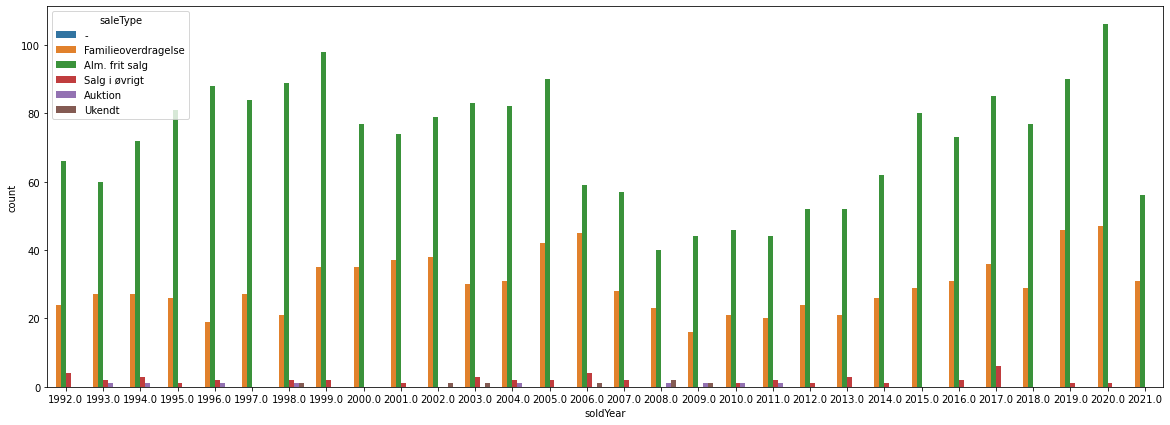

In [16]:
plt.figure(figsize=(20,7));
sns.countplot(data=salesdata,x='soldYear',hue='saleType');

**Month sold, each sale type separately.** As expected, regular sales are a summer thing and start around Easter, but look at the family sales in December!

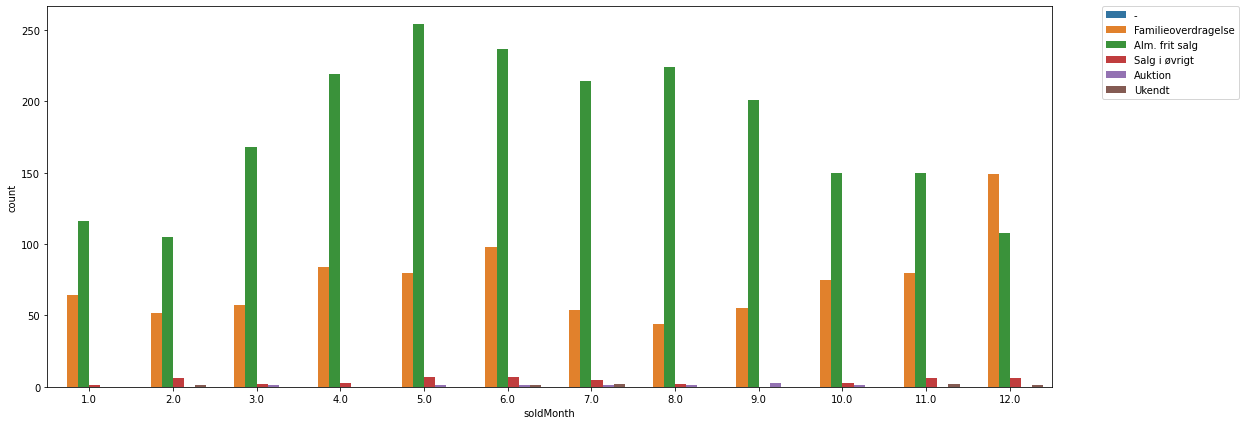

In [17]:
plt.figure(figsize=(18,7));
sns.countplot(data=salesdata,x='soldMonth',hue='saleType');
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

**Number of sales per month for each year, regular sales only.** Just to double-check the shape of the season. (And as expected, sales went up dramatically in March 2020 when a lot of people were sent home from work/school/daycare. But what happened March 2004?)

In [18]:
regularsales = salesdata[salesdata['saleType']=='Alm. frit salg']

In [19]:
regularsales.groupby(['soldYear','soldMonth'], as_index=False).count()

,soldYear,soldMonth,estateId,address,zipCode,price,soldDate,propertyType,saleType,rooms,...,latitude,longitude,municipalityCode,estateCode,city,groupKey,canGetVR,lotSize,outerWalls,roof
0,1992.0,1.0,3,3,3,3,3,3,3,3,...,3,3,3,3,3,0,3,3,3,3
1,1992.0,2.0,4,4,4,4,4,4,4,4,...,4,4,4,4,4,0,4,4,4,4
2,1992.0,3.0,4,4,4,4,4,4,4,4,...,4,4,4,4,4,0,4,4,4,4
3,1992.0,4.0,9,9,9,9,9,9,9,9,...,9,9,9,9,9,0,9,9,9,9
4,1992.0,5.0,7,7,7,7,7,7,7,7,...,7,7,7,7,7,0,7,7,7,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345,2021.0,3.0,9,9,9,9,9,9,9,9,...,9,9,9,9,9,0,9,9,9,9
346,2021.0,4.0,11,11,11,11,11,11,11,11,...,11,11,11,11,11,0,11,11,11,11
347,2021.0,5.0,7,7,7,7,7,7,7,7,...,7,7,7,7,7,0,7,7,7,7
348,2021.0,6.0,8,8,8,8,8,8,8,8,...,8,8,8,8,8,0,8,8,8,8


In [20]:
pivot = pd.pivot_table(regularsales.groupby(['soldYear','soldMonth'], as_index=False).count(),
                           'guid','soldMonth','soldYear')

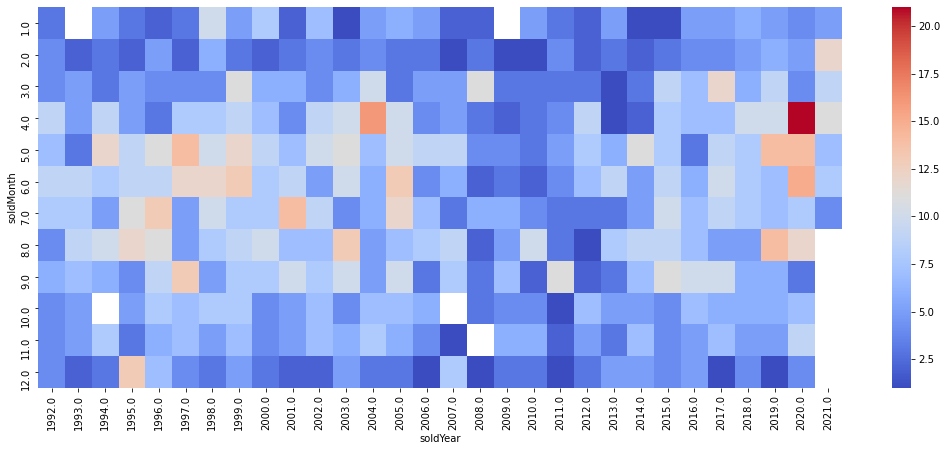

In [21]:
plt.figure(figsize=(18,7));
sns.heatmap(pivot, cmap='coolwarm');

Let's do it again but relative to the number of sales each year.

In [22]:
for year in pivot.columns:
    pivot[year] = pivot[year]/pivot[year].sum()

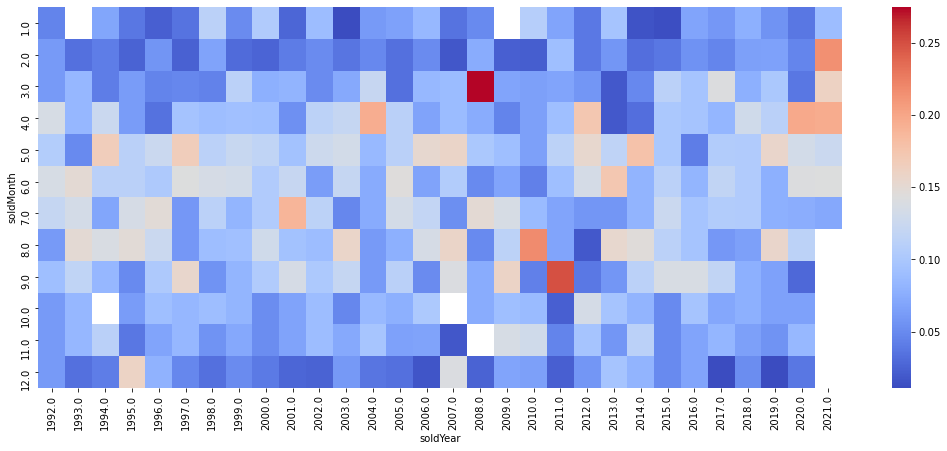

In [23]:
plt.figure(figsize=(18,7));
sns.heatmap(pivot, cmap='coolwarm');

**Number of sales per month for each year, family sales only.** Just to double-check the shape of the season. December (and lately also January) is a popular month for family sales.

In [24]:
familysales = salesdata[salesdata['saleType']=='Familieoverdragelse']

In [25]:
pivot = pd.pivot_table(familysales.groupby(['soldYear','soldMonth'], as_index=False).count(),
                           'guid','soldMonth','soldYear')

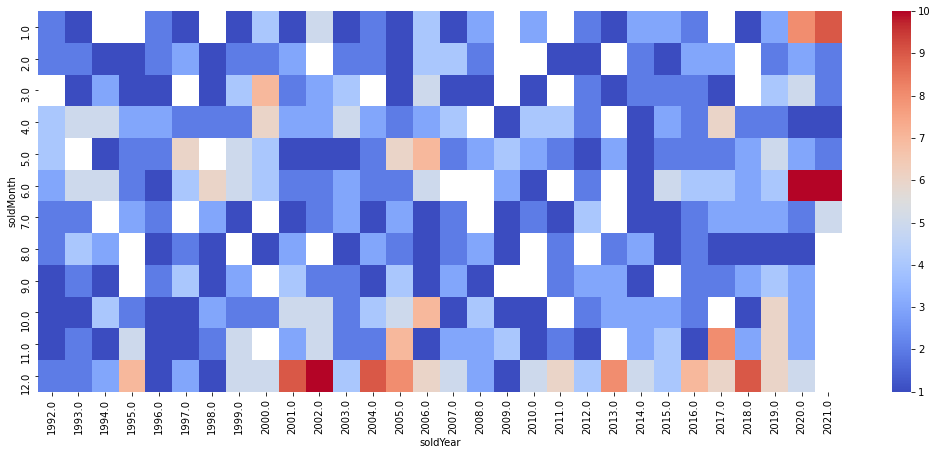

In [26]:
plt.figure(figsize=(18,7));
sns.heatmap(pivot, cmap='coolwarm');

In [27]:
for year in pivot.columns:
    pivot[year] = pivot[year]/pivot[year].sum()

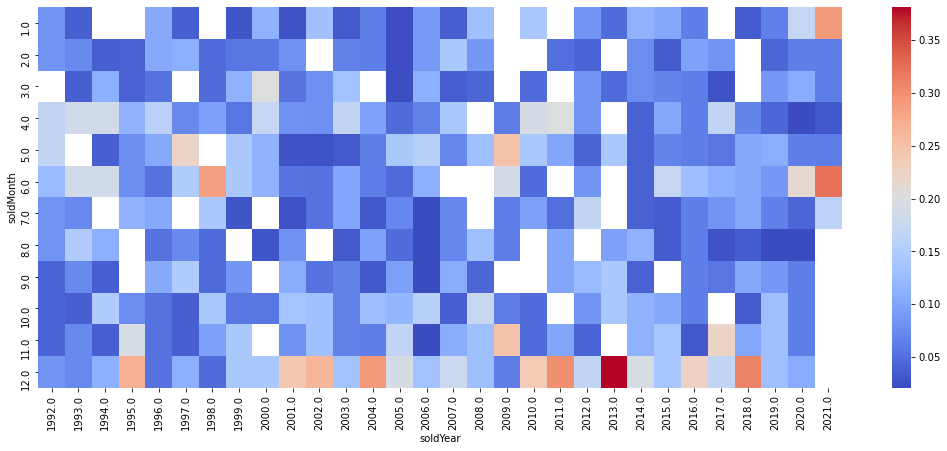

In [28]:
plt.figure(figsize=(18,7));
sns.heatmap(pivot, cmap='coolwarm');

### Price vs. year/month and sale type
Price per lot size or size might to be better to look at than price, so let's look at all three.

In [29]:
salesdata['lotSize'].describe()

count     3595.000000
mean      2381.692907
std       1505.580581
min        120.000000
25%       1867.000000
50%       2066.000000
75%       2505.500000
max      26346.000000
Name: lotSize, dtype: float64

In [30]:
salesdata['size'].describe()

count    3595.000000
mean       84.686787
std        34.476760
min        18.000000
25%        61.000000
50%        79.000000
75%       101.000000
max       298.000000
Name: size, dtype: float64

In [31]:
salesdata['priceLotSize'] = salesdata['price']/salesdata['lotSize']
salesdata['priceSize'] = salesdata['price']/salesdata['size']

In [32]:
salesdata[['priceLotSize', 'priceSize', 'price']].describe()

,priceLotSize,priceSize,price
count,3595.000000,3595.000000,3.595000e+03
mean,449.279260,11448.848320,9.191597e+05
std,573.672053,13217.858537,1.087916e+06
min,0.000000,0.000000,0.000000e+00
25%,100.189926,2765.507519,2.200000e+05
50%,283.447168,7636.363636,6.000000e+05
75%,633.140591,16930.288462,1.275000e+06
max,12500.000000,294000.000000,1.470000e+07


**Sales price each year.** We're only half-way into 2021, but the prices this year are (as expected) quite extreme.

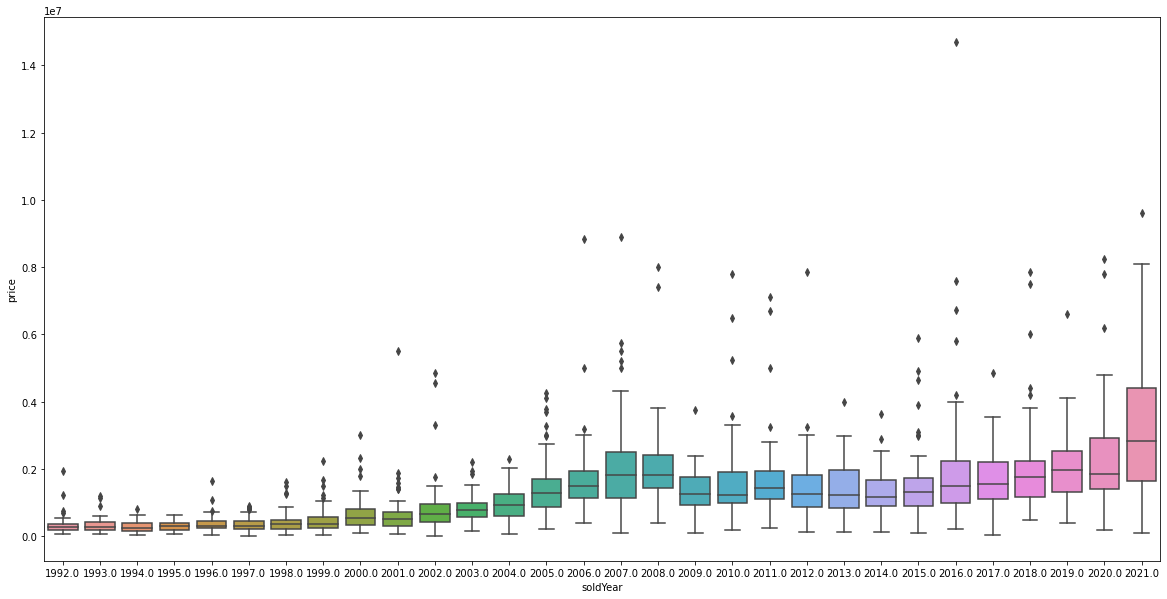

In [33]:
plt.figure(figsize=(20,10));
sns.boxplot(data=salesdata[salesdata['saleType']=='Alm. frit salg'], x='soldYear', y='price');

**Sales price each year, regular sales and family sales compared.** As expected, the family sales are generally lower in price. The difference just gets bigger each year, but I would really like to see it relative to the lot size before I decide that this is appalling.

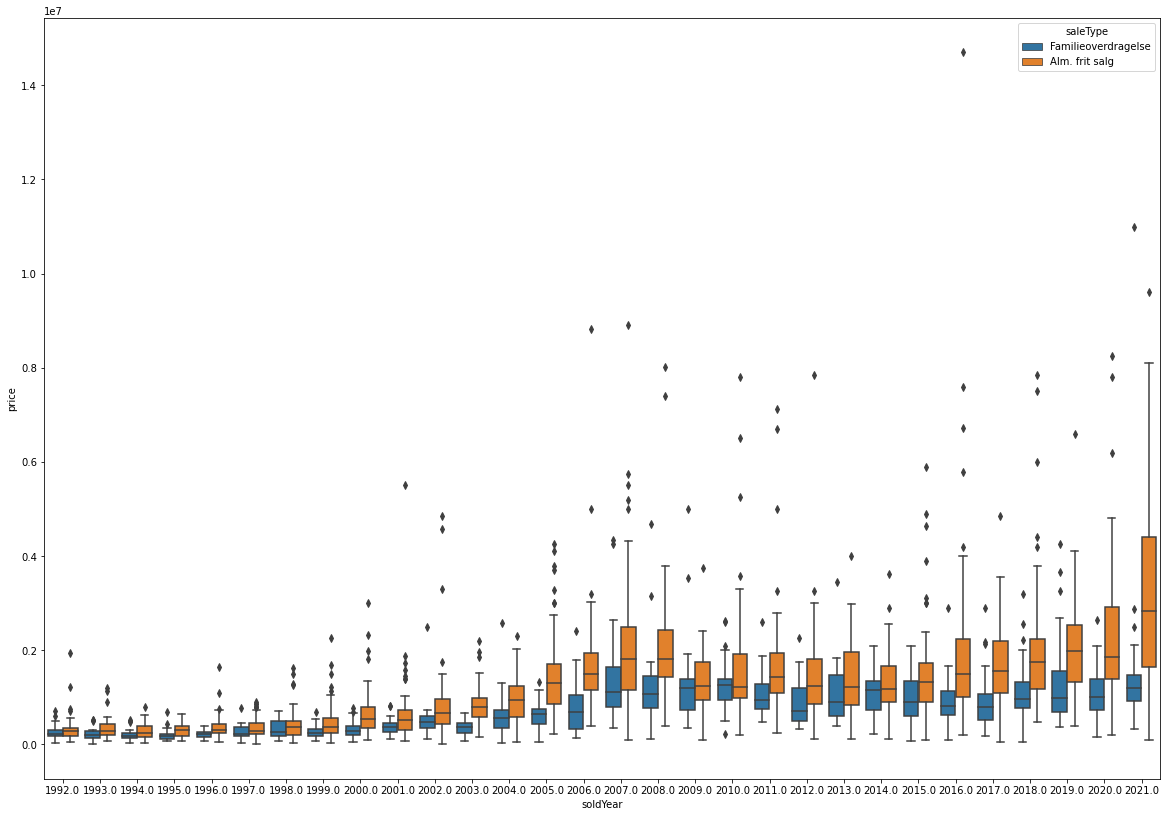

In [34]:
plt.figure(figsize=(20,14));
sns.boxplot(data=salesdata[(salesdata['saleType']=='Alm. frit salg') | (salesdata['saleType']=='Familieoverdragelse')], x='soldYear', y='price', hue='saleType');

**Sales price each month, regular sales and family sales compared.** This is just to confirm that the time of year matters less when it comes to price.

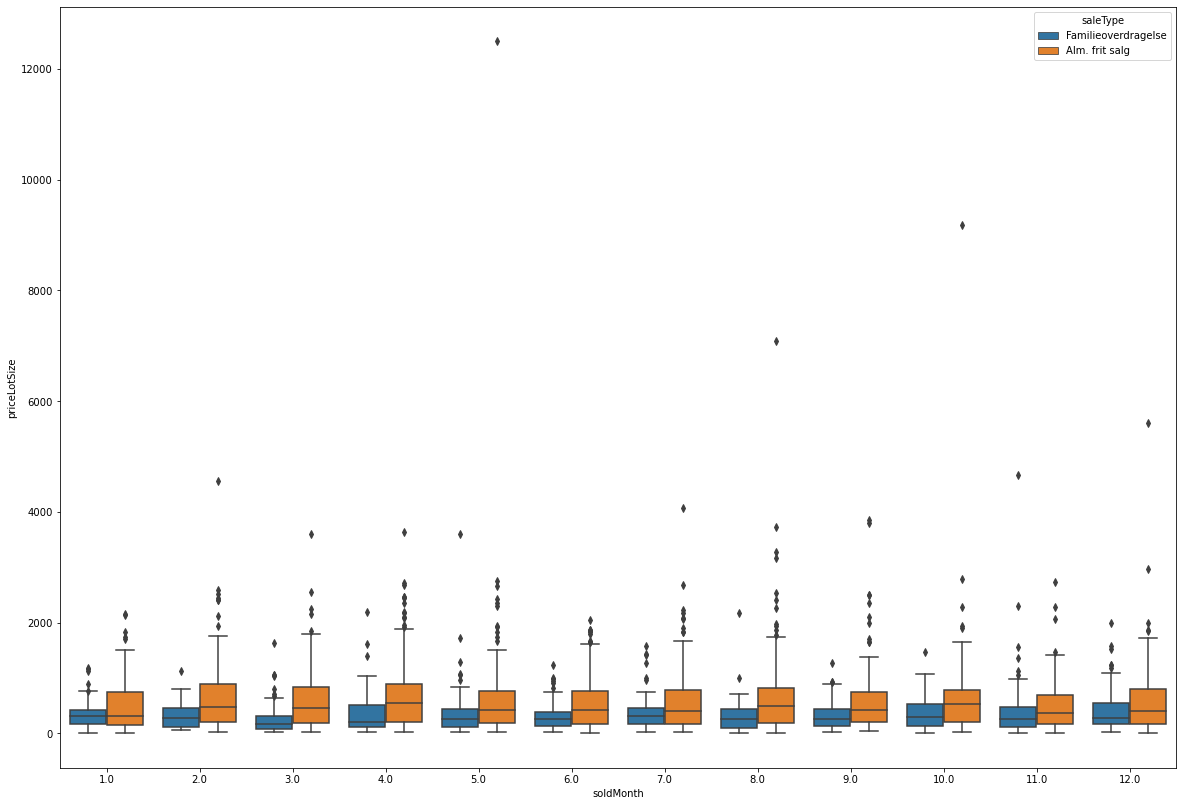

In [35]:
plt.figure(figsize=(20,14));
sns.boxplot(data=salesdata[(salesdata['saleType']=='Alm. frit salg') | (salesdata['saleType']=='Familieoverdragelse')], x='soldMonth', y='priceLotSize', hue='saleType');

### Looking at price relative to size and lot size for regular sales in 2020
Nothing surprising except that size seems to matter more than lot size.

In [36]:
reducedsalesdata = salesdata.query('soldYear == 2020 and saleType == "Alm. frit salg"')

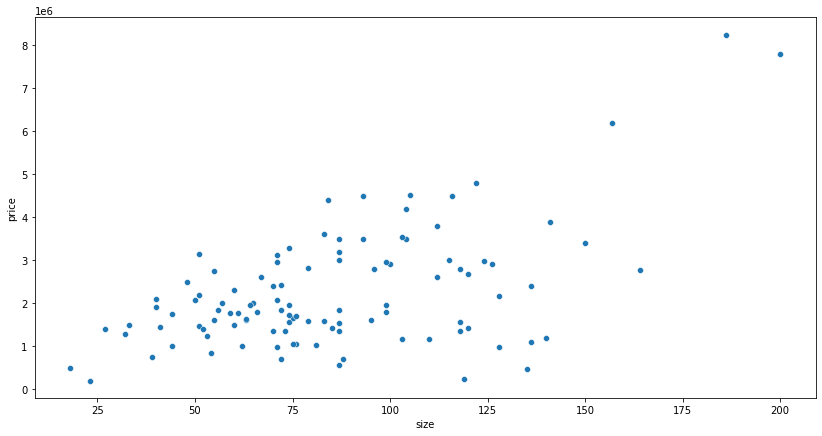

In [37]:
plt.figure(figsize=(14,7))
sns.scatterplot(data=reducedsalesdata,
                x='size', y='price');

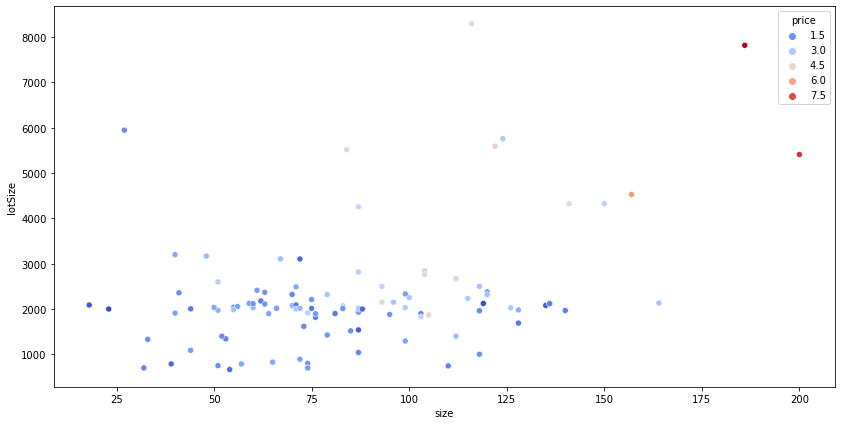

In [38]:
plt.figure(figsize=(14,7))
sns.scatterplot(data=reducedsalesdata,
                x='size', y='lotSize', hue='price', palette='coolwarm');

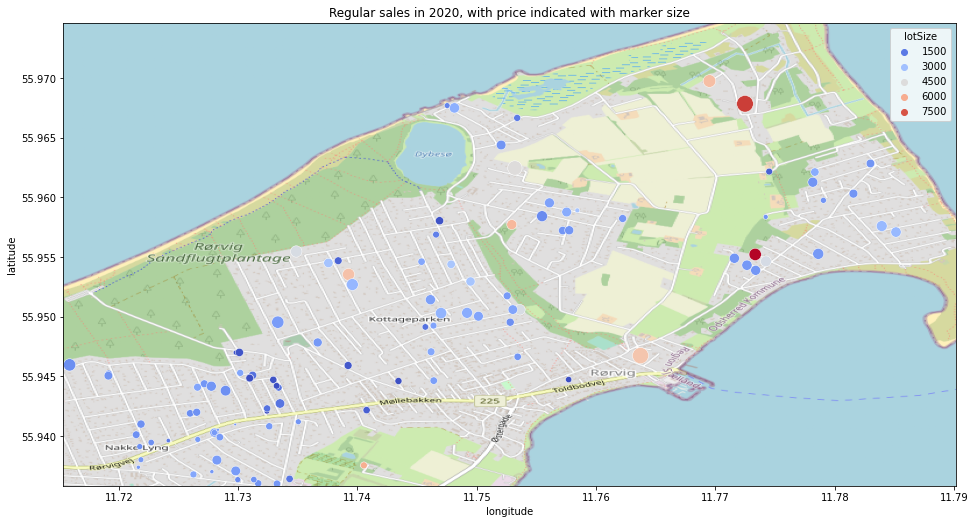

In [39]:
include_map(reducedsalesdata, hue='lotSize', palette='coolwarm',
            s=reducedsalesdata['price']/30000,
           title="Regular sales in 2020, with price indicated with marker size")

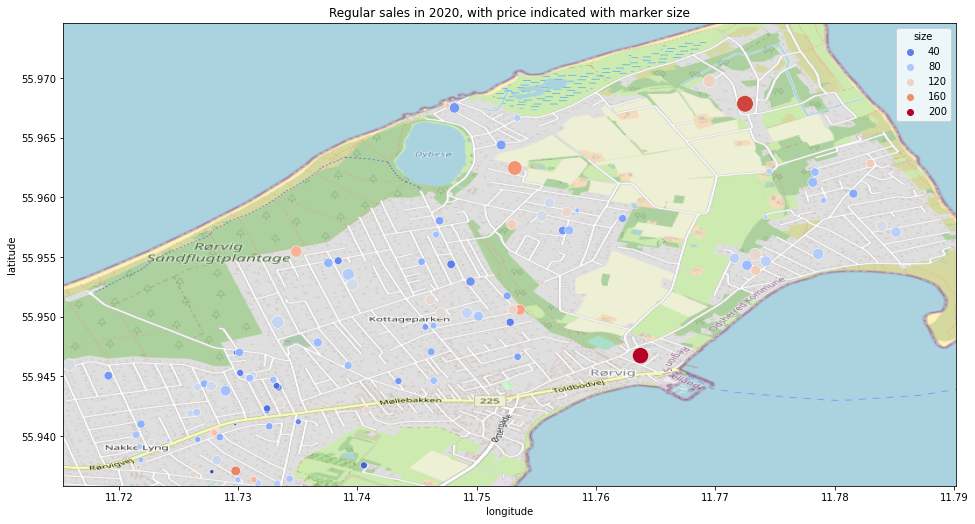

In [40]:
include_map(reducedsalesdata, hue='size', palette='coolwarm',
            s=reducedsalesdata['price']/30000,
           title="Regular sales in 2020, with price indicated with marker size")

### Regular vs. family sales in 2020

In [41]:
reducedsalesdata = salesdata.query('soldYear == 2020 and (saleType == "Alm. frit salg" or saleType == "Familieoverdragelse")')

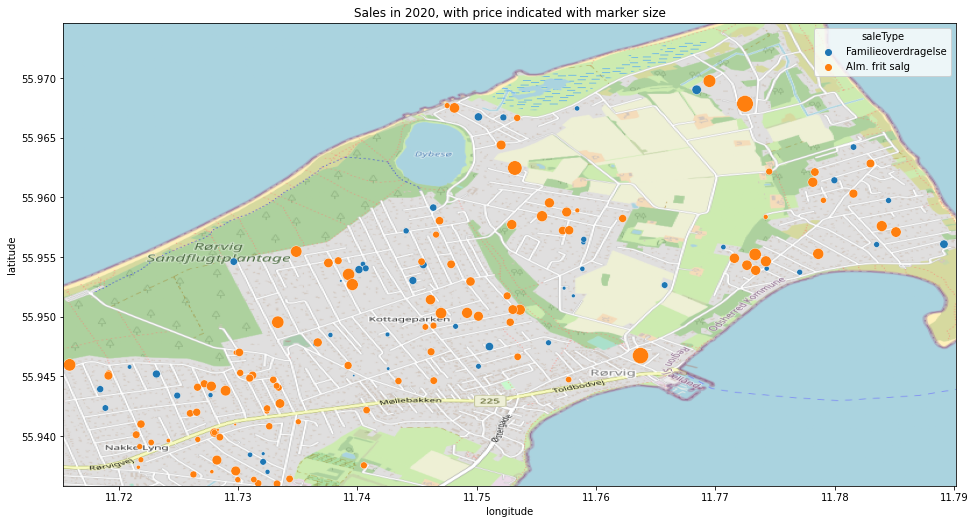

In [42]:
include_map(reducedsalesdata, hue='saleType', 
            s=reducedsalesdata['price']/30000,
           title="Sales in 2020, with price indicated with marker size")

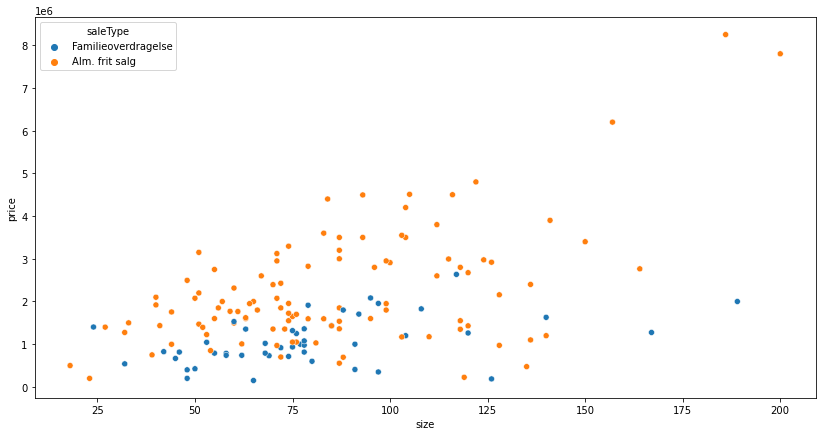

In [43]:
plt.figure(figsize=(14,7))
sns.scatterplot(data=reducedsalesdata, hue='saleType',
                x='size', y='price');